# <center>4.1 CatBoost</center>

<center><img src="https://mljar.com/images/machine-learning/catboost.png"></center>

**CatBoost** — это open-source библиотека градиентного бустинга на решающих деревьях с поддержкой категориальных фичей из коробки, преемник алгоритма MatrixNet, разработанного Яндексом.<br>
В плане простоты использования и легкости входа для новичков, пожалуй является топ-1 библиотекой для табличных данных и вот почему:
* Принимает категориальные фичи сразу без всякой предварительной обработки.
* Чтобы перенести обучение с CPU на GPU достаточно поменять значение 1 параметра, без установки доп.пакетов или специальных версий, как в других библиотеках
* Даже с дефолтными параметрами выдает хорошую точность модели, так как основные параметры не константные, а подбираются самой библиотекой, в зависимости от размера входных данных.
* Может принимать текстовые признаки, эмбеддинги, временные признаки.
* Без дополнительных манипуляций и оберток встраивается в стандартные пайплайны (например, sklearn).

В общем, рекомендуем начинать всегда именно с этой библиотеки, особенно, если только начинаете вкатываться в соревнавания.<br>
Алгоритм примерно следующий:
1. Скачали данные
2. Провели быстрый EDA
3. Собрали список кат-фичей, закинули данные в CatBoost
4. Посмотрели, что модель дает с дефолтными фичами и параметрами.
5. Отправили сабмишен на лидерборд.

После этого уже начинаем настройку валидации, feature engeneering, тюнинг модели и прочие манипуляции.

In [1]:
!pip install --upgrade pandas -q
!pip install seaborn catboost -q

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from tqdm.notebook import tqdm

# Импортируем train

train (2337, 9) test (1913, 8)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_2
1560,M-2273396F,Skoda Rapid,economy,petrol,6.46,2016,41247,2019,electro_bug
671,O-1123087f,Smart ForFour,economy,petrol,5.32,2014,4454,2019,engine_overheat
1983,i60361443P,Renault Kaptur,standart,petrol,3.82,2012,41157,2014,engine_overheat
1676,G21583307F,Smart Coupe,economy,petrol,3.76,2017,57743,2021,gear_stick
882,m10044876m,Nissan Qashqai,standart,petrol,2.10,2014,2567,2016,gear_stick


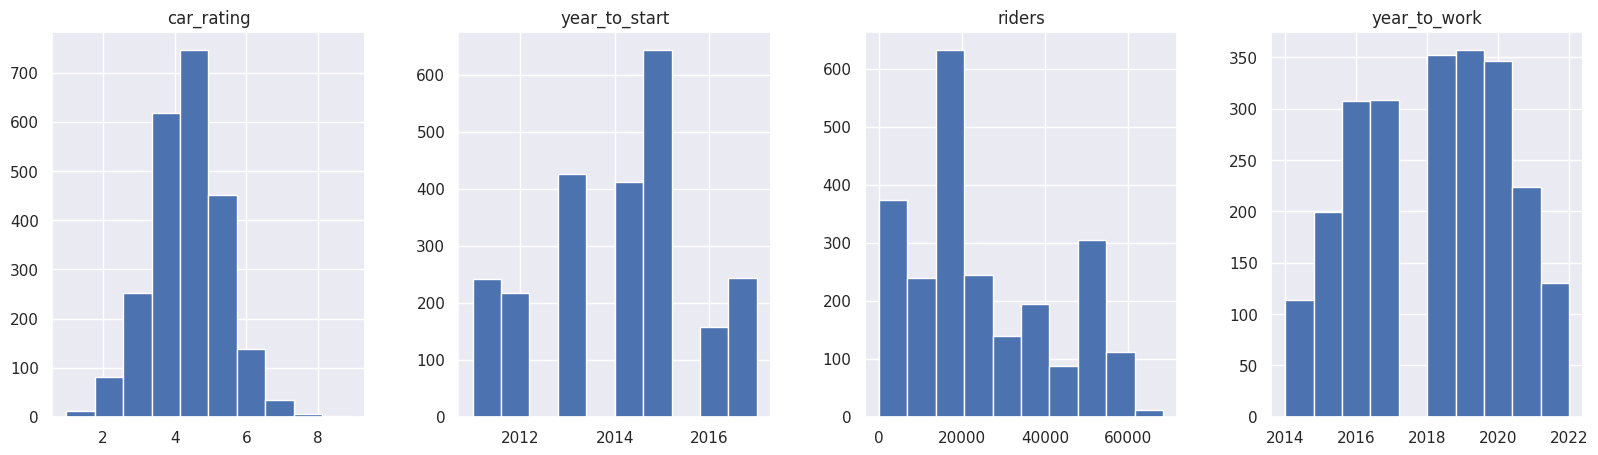

In [3]:
path = '../data/car_train.csv'
train = pd.read_csv(path).drop('target_1', axis=1)

path = '../data/car_test.csv'
test = pd.read_csv(path)

print('train', train.shape, 'test', test.shape)
train.hist(figsize=(25, 5), layout = (-1, 5))
train.sample(5)

In [4]:
# rides

In [5]:
path = '../data/rides_info.csv'
rides = pd.read_csv(path)


f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating = ('speed_avg', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   speed_min = ('speed_max', 'min'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'), 
                                                   deviation_normal_mean = ('deviation_normal', 'mean'),
                                                   deviation_normal_std = ('deviation_normal', 'std'),
                                                   user_uniq = ('user_id', f))



def add_featues(df):
    
    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')
    
    return df
    
    
train = add_featues(train)
test = add_featues(test)

train.sample(2)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_2,mean_rating,distance_sum,rating_min,speed_max,speed_min,user_ride_quality_median,deviation_normal_mean,deviation_normal_std,user_uniq
451,m-4630662O,Smart Coupe,economy,petrol,4.18,2016,32059,2021,break_bug,43.994253,7.644536e+07,0.1,110.716714,34.0,11.566972,-2.199282,2.834621,173
161,X-6435694U,Renault Sandero,standart,petrol,4.84,2013,17498,2019,electro_bug,50.057471,7.664714e+07,0.0,169.343623,33.0,-12.602946,-5.918138,6.484631,173


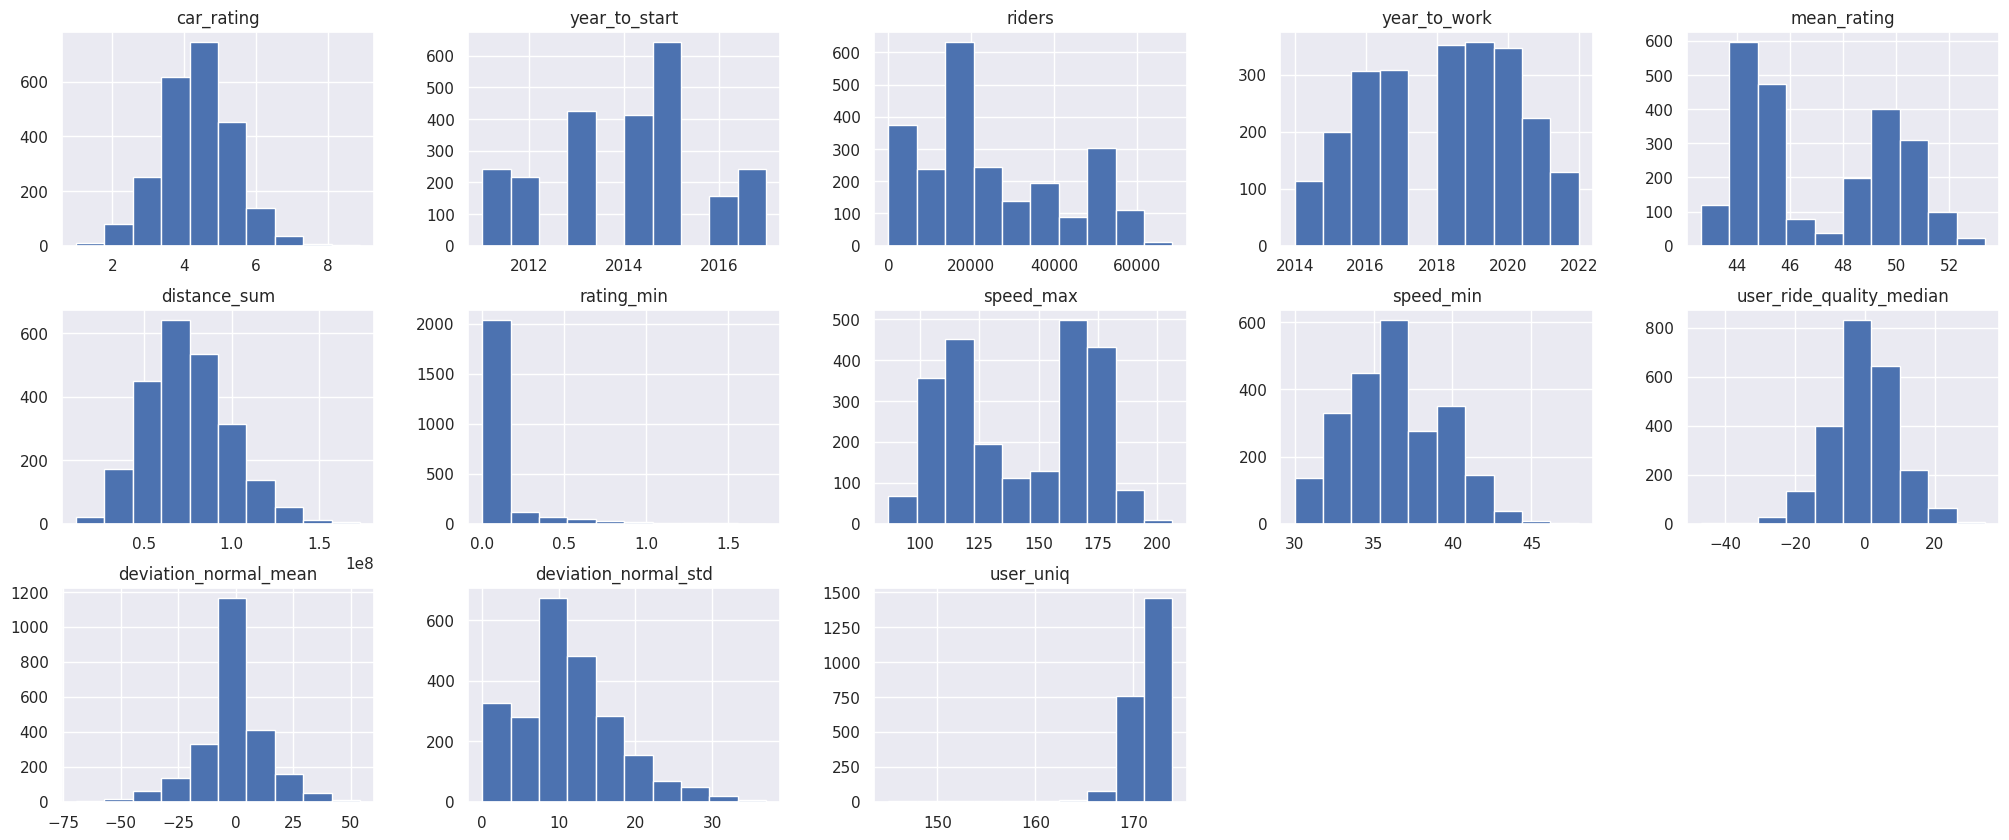

In [6]:
train.hist(figsize=(25, 10), layout = (-1, 5));

# Группируем признаки (фичи)

In [7]:
features2drop = ['car_id'] 
targets = ['target_2']  #
cat_features = ['model', 'car_type', 'fuel_type'] 

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)] #+ cat_features 
num_features = [i for i in filtered_features if i not in cat_features]

print('cat_features', cat_features)
print('num_features', len(num_features))
print('targets', targets)

for c in cat_features: # Избавлеямся от NaN'ов
    train[c] = train[c].astype(str)
    test[c] = test[c].astype(str)

cat_features ['model', 'car_type', 'fuel_type']
num_features 13
targets ['target_2']


# Catboost Classifier

Задача - использовать  CatBoost для классификации поломок. Посмотрим, сможет ли алгоритм справиться с поставленной задачей.

Перед использованием рассмотрим параметры модели (подробнее читай здесь): 

In [8]:
!pip install catboost -q
from catboost import Pool, CatBoostClassifier #, CatBoostRegressor 

In [9]:
# Какие параметры есть в Catboost? посмотрим через shift + Tab
CatBoostClassifier()

* `iterations` (синонимы `num_boost_round`, `n_estimators`, `num_trees`) - максимальное количество деревьев, используемых в модели (по умолчанию **`1000`**). Значение может быть ниже заданного, если используются другие параметры, накладывающие ограничение на количество деревьев;
* `learning_rate` - скорость обучения;
* `depth (max_depth)` - глубина дерева (по умолчанию 6, максимальное значение - 16); 
* `cat_features` - список наименований категориальных признаков; 

* `loss_function` - функция потерь, которую модель минимизирует в процессе обучения (подмножество из списка);
* `eval_metric` - валидационная метрика, используемая для ранней остановки (в зависимости от задачи ссылки здесь);
* `custom_metric` - отслеживаемые метрики (список доступен здесь). Лучшие метрики в процессе обучения можно вернуть методом `get_best_score`;
* `early_stopping_rounds` - устанавливает количество итераций для останова, если на их протяжении метрика качества не улучшалась по сравнению с оптимальной;
* `use_best_model` - если **`True`**, в результате обучения с ранней остановкой будет возвращаться модель, полученная на итерации (количеством деревьев) с лучшей метрикой на валидационной выборке;

* `l2_leaf_reg (reg_lambda)` - коэффициент регуляризации функции потерь;
* `min_data_in_leaf (min_child_samples)` - минимальное количество узлов в листе;
* `max_leaves (num_leaves)` - максимальное количество листьев в дереве;
* `subsample` - часть исходной выборки, отбираемая для обучения каждого дерева;
* `colsample_bylevel` - доля признаков, используемая для отбора на каждом сплите;
* `max_bin` - максимальное число бинов, на которые разбиваются признаки

* `classes_count` - количество классов для многоклассовой классификации;
* `class_weights` - веса классов в моделях классификации. Используется для устранения дисбаланса (например, вес `positive`= `количество_negative`/`количество_positive`);
* `auto_class_weights` - устраняет дисбаланс автоматически (значения - **`Balanced`**, **`SqrtBalanced`**);
* `scale_pos_weight` - задает вес для положительного класса; Среди параметров `scale_pos_weight`, `auto_class_weights`, `class_weights` одновременно используется только один.

* `random_seed` - инициализирующее значение для используемого генератора случайных чисел, чтобы обеспечить воспроизводимость эксперимента;
* `task_type` - используемое для вычислений устройство (**`CPU`**, **`GPU`**);
* `thread_count` - число используемых для обучения потоков (по умолчанию = **`-1`**, что означает - все ядра процессора);
* `verbose` - объем выводимой информации (**`False`** - подавляем сообщения).

In [10]:
from sklearn.model_selection import KFold # k-фолдная валидация

In [11]:
n_splits = 3 # kfolds
print('num folds', n_splits)
targets = ['target_2']
clfs = []

# параметры валидации, обучение будет идти на n_splits фолдах

X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train[targets]

scores = []
kf = KFold(n_splits=n_splits, shuffle=True, random_state=7575)
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

    print(X_train.shape, y_train.shape)
    clf = CatBoostClassifier(
                          depth = 4,
                          iterations = 3500, 
                          learning_rate = 0.05953207713558619,
                          
                          loss_function='MultiClass', # MultiLogloss
                          # eval_metric = 'Precision', # F1:macro', #'AUC:hints=skip_train~false',
                          custom_metric =['Recall'], # 'AUC', 'Accuracy'],
                            
                          # Главная фишка катбуста - работа с категориальными признаками
                          cat_features = cat_features, 
        
                          # Регуляризация и ускорение
                          colsample_bylevel =  0.09874152157026818,
                          subsample = 0.9563761143682146,
                             
                          l2_leaf_reg = 9,
                          min_data_in_leaf = 243,
                          max_bin = 187,
                             
                          bootstrap_type='Bernoulli',
                          # ignored_features = ignored_features,
                          task_type='CPU',
                          random_seed=42,   
                          auto_class_weights = 'SqrtBalanced',
                             
                          early_stopping_rounds = 5
                            )

    clfs.append(clf)

    clf.fit(train_dataset, eval_set=eval_dataset,
            verbose = 100, use_best_model = True, plot = False)

    # scores.append(clf.best_score_['validation']['MultiClass'])
    scores.append(np.mean([v for k, v in clf.best_score_['validation'].items() if 'Recall' in k], dtype = 'float16'))
    # clf.save_model("../tmp_data/cool_catboost_model_{}_deep".format(n))

assert len(clfs) == n_splits
print('mean Recalls core --------->', np.mean(scores, dtype = 'float16'), np.std(scores, dtype = 'float16'))

num folds 3
(1558, 16) (1558, 1)
0:	learn: 2.1970043	test: 2.1971111	best: 2.1971111 (0)	total: 46.8ms	remaining: 2m 43s
100:	learn: 1.1639194	test: 1.2146361	best: 1.2146361 (100)	total: 203ms	remaining: 6.84s
200:	learn: 0.8984555	test: 0.9834927	best: 0.9834927 (200)	total: 355ms	remaining: 5.83s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.9520713532
bestIteration = 243

Shrink model to first 244 iterations.
(1558, 16) (1558, 1)
0:	learn: 2.1969763	test: 2.1971240	best: 2.1971240 (0)	total: 1.29ms	remaining: 4.52s
100:	learn: 1.1316883	test: 1.1836160	best: 1.1836160 (100)	total: 160ms	remaining: 5.4s
200:	learn: 0.8935286	test: 0.9701645	best: 0.9701620 (199)	total: 292ms	remaining: 4.79s
300:	learn: 0.7897177	test: 0.9018024	best: 0.9018024 (300)	total: 435ms	remaining: 4.62s
400:	learn: 0.7233164	test: 0.8640026	best: 0.8639167 (399)	total: 587ms	remaining: 4.54s
Stopped by overfitting detector  (5 iterations wait)

bestTest = 0.8560558798
bestIteration = 4

* `cat_features` — массив с категориальными столбцами.
* `ignored_features` — указывает на признаки, которые нужно игнорировать в процессе обучения.
* `task_type` – используете вы **`CPU`** или **`GPU`**. По умолчанию стоит **`CPU`**.
* `devices` — идентификаторы устройств **`GPU`**, которые будут использоваться для обучения.

# Best practices по настройке Catboost

- Категориальные признаки помещать в `cat_features`. Сами не кодируем. 
- Фиксируем `random_seed`
- Помещать данные в `Pool` для ускорения. (Квантилизация заранее)
- Иметь `eval_set`, чтобы выставить `early_stopping_rounds`
- Регуляризационные параметы `colsample_bylevel` и `subsample` и другие
- `max_depth` как можно меньше при том же уровне точности
- `iterations` должен быть с запасом для удобства `early_stopping_rounds`
- `learning_rate` подбирается по метрике

# Анализ и интерпретация модели

Всего признаков 16 Усреднее по 3-ти моделям: 
На график нанесено топ-100 признаков


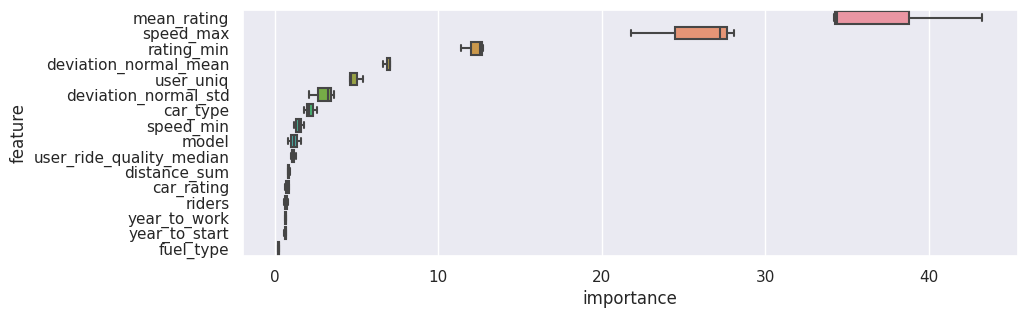

In [12]:
def plot_importance(df, best_model, height, top_n=50):
    
    fi = pd.DataFrame(index = df.columns, columns = [])
    for i, m in enumerate(best_model):
        fi[f'm_{i}'] = m.get_feature_importance()

    fi = fi.stack().reset_index().iloc[:,[0, 2]]#.to_frame()
    fi.columns = ['feature','importance']

    cols_ord = list(fi.groupby('feature')['importance'].mean().sort_values(ascending=False).index)
    print('Всего признаков {} Усреднее по {}-ти моделям: '.format(len(cols_ord), len(best_model)) )
    cols_ord = cols_ord[:top_n]
    
    fi = fi[fi['feature'].isin(cols_ord)]
    
    plt.figure(figsize=(10, len(cols_ord)*height))
    b = sns.boxplot(data=fi, y='feature', x='importance', orient='h', order=cols_ord)
    
    print('На график нанесено топ-{} признаков'.format(top_n))
    return fi.groupby(by =['feature'], as_index=False)['importance'].mean().sort_values(by='importance', ascending=False)

df_feats_imp = plot_importance(train[filtered_features].drop(targets, axis=1, errors='ignore'), clfs, 0.20, top_n=100)


In [13]:
# !conda install python-graphviz -y

In [14]:
# clfs[0].plot_tree(
#     tree_idx=3,
#     pool=train_dataset
# )

In [15]:
# !pip install --upgrade graphviz 

# Теперь произведем инференс модели

In [16]:
# массив для записи финального прогноза size*n_class
y_pred = np.zeros((test.shape[0], train[targets].nunique()[0]))  
scores = []
for n, clf in enumerate(clfs):
    y_pred += clf.predict_proba(test[filtered_features])#[:,1]
    score = np.mean([v for k, v in clf.best_score_['validation'].items() if 'Recall' in k], dtype = 'float16')
    scores.append(score)

print('mean Recall score', np.mean(scores, dtype = 'float16'), np.std(scores, dtype = 'float16'),'\n')


mean Recall score 0.7456 0.01312 



# Сохраняем решение, конвертируя в класс

In [2]:
f = lambda x: clf.classes_[x]
test['target_2'] = list(map(f, y_pred.argmax(axis=1)))
test[['car_id', 'target_2']].to_csv('../subs/catboost_kfold.csv', index=False)
test[['car_id', 'target_2']].head()

NameError: name 'y_pred' is not defined

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def chect_test(X_test, y_test, clfs):
    # массив для записи финального результата
    y_pred = np.zeros((X_test.shape[0], 9))
    scores = {'MultiClass':[], 'Precision' : [], 'Recall' : []}
    for n, clf in enumerate(clfs):
        y_pred += clf.predict_proba(X_test[filtered_features])#[:,1]
        scores['MultiClass'].append(clf.best_score_['validation']['MultiClass'])

    y_pred =  np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_test['target_2'], y_pred, normalize='all')
    cmd = ConfusionMatrixDisplay(cm) #, display_labels=sorted(y_test['crop'].unique().tolist())
    cmd.plot(xticks_rotation=45, cmap = 'viridis_r');

# chect_test(X_test, y_test, clfs)

# y_test['target_2'].shape#.value_counts()
# y_pred.shape

# Feature Importance с помощью Shap

In [ ]:
!pip install catboost -q
!pip uninstall opencv-python -y -q
!pip install opencv-python shap -q

In [ ]:
import shap

shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(clfs[-1])


train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
shap_values = explainer.shap_values(train_dataset)

# shap.dependence_plot("RM", shap_values, X)

shap.summary_plot(shap_values, X_train, max_display = 25)

# Какие еще полезные параметры есть в Catboost?

In [ ]:
from catboost import CatBoost

fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    # cat_features = cat_features, 
    leaf_estimation_iterations=5,
    max_ctr_complexity=1,
    early_stopping_rounds = 10,
)

fast_model.fit(
    train_dataset, eval_set=eval_dataset,
    verbose=100,
    # plot=True
);

Многие знают, что такое `random_seed`, `learning_rate`, `iterations`, поэтому обсудим другие:
* `boosting_type` – это тип бустинга, который мы будем использовать при обучении, значение **Plain** дает качество хуже, но работает быстрее, есть другой более затратный параметр — **Ordered**, но дает лучшее качество.
* `bootstrap_type` – это тип сэмплирования, когда мы строим дерево, построение идет не по всем объектам обучающей выборки, а по нескольким объектам
* `subsample` – это вероятность, по которой будет выбираться каждый объект для построения дерева. Параметры `bootstrap_type` и `subsample` идут в связке.
* `one_hot_max_size` – это горячее кодирование определенных переменных выборки (конвертируем каждое категориальное значение в новый категориальный столбец и присваиваем этим столбцам двоичное значение 1 или 0). 
* `RSM` - он аналогичен `subsample`, только используется для фичей.
* `leaf_estimation_iterations` – это количество итераций подсчета значений в листьях.
* `max_ctr_complexity` – это длина перебора комбинаций фичей нашей выборки.

# Какие параметры использовались в модели?

In [ ]:
fs2noshow = ['boosting_type','boosting_type', 'max_ctr_complexity', 'leaf_estimation_iterations', 'rsm', 'one_hot_max_size', 'subsample', 'depth', 'task_type']

for key, value in clfs[0].get_all_params().items():
    if key not in fs2noshow:
        print('{}, {}'.format(key,value))

# Давайте рассмотрим параметры в CatBoost, которые еще не обсуждали:

* `loss_function` или `objective` – показатель, используемый для обучения. Есть регрессионные показатели, такие как среднеквадратичная ошибка для регрессии и logloss для классификации.
* `eval_metric` – метрика, используемая для обнаружения переобучения.
* `Iterations` – максимальное количество построенных деревьев, по умолчанию **`1000`**. Альтернативные названия `num_boost_round`, `n_estimators` и `num_trees`.
* `learning_rate` или `eta` – скорость обучения, которая определяет насколько быстро или медленно модель будет учиться. Значение по умолчанию обычно равно **`0.03`**.
* `random_seed` или `random_state` – случайное зерно, используемое для обучения.
* `l2_leaf_reg` или `reg_lambda` – коэффициент при члене регуляризации **`L2`** функции потерь. Значение по умолчанию – **`3.0`**.
* `bootstrap_type` – определяет метод сэмплинга весов объектов, например это может быть Байес, Бернулли, многомерная случайная величина или Пуассон.
* `boosting_type` — схема бустинга. Она может быть простой для классической схемы градиентного бустинга или упорядоченной, что обеспечит лучшее качество на небольших наборах данных.
* `depth` = глубина дерева.

* `grow_policy` – определяет, как будет применяться жадный алгоритм поиска. Может стоять в значении **`SymmetricTree`**, **`Depthwise`** или **`Lossguide`**. По умолчанию **`SymmetricTree`**. В **`SymmetricTree`** дерево строится уровень за уровнем, пока не достигнет необходимой глубины. На каждом шаге листья с предыдущего дерева разделяются с тем же условием. При выборе параметра **`Depthwise`** дерево строится шаг за шагом, пока не достигнет необходимой глубины. Листья разделяются с использованием условия, которое приводит к лучшему уменьшению потерь. В **`Lossguide`** дерево строится по листьям до тех пор, пока не будет достигнуто заданное количество листьев. На каждом шаге разделяется нетерминальный лист с лучшим уменьшением потерь.

* `min_data_in_leaf` или `min_child_samples` – это минимальное количество обучающих сэмплов в листе. Этот параметр используется только с политиками роста Lossguide и Depthwise.
* `max_leaves` или `num_leaves` – этот параметр используется только с политикой Lossguide и определяет количество листьев в дереве.
* `nan_mode` – метод работы с пропущенными значениями. Параметры **`Forbidden`**, **`Min`** и **`Max`**. При использовании **`Forbidden`** наличие пропущенных значений вызовет ошибку. При использовании параметра Min пропущенные значения будут приняты за максимальные значения для данного признака. В Max пропущенные значения будут приняты как минимальные значения для данного признака.
* `leaf_estimation_backtracking` – тип бэктрекинга, использующийся при градиентном спуске. По умолчанию используется **`AnyImprovement`**. **`AnyImprovement`** уменьшает шаг спуска до того, как значение функции потерь будет меньшим, чем оно было на последней итерации. **`Armijo`** уменьшает шаг спуска до тех пор, пока не будет выполнено условие Вольфе.
* `score_function` – тип оценки, используемой для выбора следующего разбиения при построении дерева. **`Cosine`** используется по умолчанию. Другие доступные варианты **`L2`**, **`NewtonL2`** и **`NewtonCosine`**.
* `early_stopping_rounds` — если стоит **`True`**, устанавливает тип детектора переобучения в **`Iter`** и останавливает обучение, когда достигается оптимальное значение.
* `classes_count` – количество классов для задач мультиклассификации.
* `text_features` — используется для объявления текстовых столбцов в задачах классификации.

# Сохраняем и подгружаем модель

In [ ]:
params = {
        'iterations':100,
        'learning_rate': 0.001,
        'depth' : 7, 
        'bootstrap_type' : 'Bernoulli',
        'subsample':0.9,
        'random_seed' : 7575
}


clf = CatBoostClassifier(**params)
                         
clf = clf.fit(
    train_dataset, eval_set=eval_dataset,
    verbose=False
)

print(clf.get_params())

In [ ]:
clf.save_model('../others/catboost_model.json')
clf.save_model('../others/catboost_model.bin')

Теперь загрузим нашу модель и проверим параметры:

In [ ]:
new_clf = CatBoostClassifier()
new_clf.load_model('../others/catboost_model.json')

In [ ]:
print(new_clf.get_params())

# Литература
* https://habr.com/ru/company/ods/blog/645887/ Очень подробная статья про работу Catboost, если вы не знаете, как он работает
* https://habr.com/ru/post/594077/ часть 1 от Яндекса 
* https://habr.com/ru/post/599827/ часть 2 от Яндекса
* https://habr.com/ru/post/648939/ часть 3 от Яндекса

# Задания и вопросы по Catboost
- Cat_features ванхотить
- Вопросы про тюнинг 
- Гиппер-параметры через соответствие
- Способы регуляризации
- Что увеличивает скрость? Как увеличить точность? Как увеличить стабильность? 
- Хитрые гипер-параметры спросить про их смысл